# VTIimplementation

First of all, it is necessary to import some Devito modules and other packages that will be used in the implementation.

In [1]:
import numpy as np
from devito import (Function, TimeFunction, cos, sin, solve,
                    Eq, Operator, configuration, norm)
from examples.seismic import TimeAxis, RickerSource, Receiver, demo_model
from matplotlib import pyplot as plt

In [2]:
# NBVAL_IGNORE_OUTPUT   

shape   = (101,101) # 101x101 grid
spacing = (10.,10.) # spacing of 10 meters
origin  = (0.,0.)  
nbl = 0  # number of pad points

model = demo_model('layers-tti', spacing=spacing, space_order=2,
                   shape=shape, nbl=nbl, nlayers=1)

# initialize Thomsem parameters to those used in Mu et al., (2020)
model.update('vp', np.ones(shape)*3.6) # km/s
model.update('epsilon', np.ones(shape)*0)#.23)
model.update('delta', np.ones(shape)*0)#*0.17)
# model.update('theta', np.ones(shape)*(45.*(np.pi/180.))) # radians
model.update('theta', np.ones(shape)*0) # radians

In [3]:
# Get symbols from model
theta = model.theta
delta = model.delta
epsilon = model.epsilon
m = model.m

# Use trigonometric functions from Devito
costheta  = cos(theta)
sintheta  = sin(theta)
cos2theta = cos(2*theta)
sin2theta = sin(2*theta)
sin4theta = sin(4*theta)

Accordingly to [Mu et al., (2020)](https://library.seg.org/doi/10.1190/geo2019-0320.1), the time sampling can be chosen as 
$$
\Delta t < \frac{\Delta d}{\pi \cdot (v_{p})_{max}}\sqrt{\dfrac{1}{(1+\eta_{max}|\cos\theta-\sin\theta|_{max}^{2})}}
$$,

where $\eta_{max}$ denotes the maximum value between $|\epsilon|_{max}$ and $|\delta|_{max}$, $|cos\theta-sin\theta|_{max}$ is the maximum value of $|cos\theta-sin\theta|$.

In [4]:
# NBVAL_IGNORE_OUTPUT

# Values used to compute the time sampling
epsilonmax = np.max(np.abs(epsilon.data[:]))
deltamax = np.max(np.abs(delta.data[:]))
etamax = max(epsilonmax, deltamax)
vmax = model._max_vp
max_cos_sin = np.amax(np.abs(np.cos(theta.data[:]) - np.sin(theta.data[:])))
dvalue = min(spacing)

The next step is to define the simulation time. It has to be small enough to avoid reflections from borders. Note we will use the `dt` computed below rather than the one provided by the property() function `critical_dt` in the `SeismicModel` class, as the latter only works for the coupled pseudoacoustic equation.

In [5]:
# Compute the dt and set time range
t0 = 0.   #  Simulation time start
tn = 150. #  Simulation time end (0.15 second = 150 msec)
dt = (dvalue/(np.pi*vmax))*np.sqrt(1/(1+etamax*(max_cos_sin)**2)) # eq. above (cell 3)
time_range = TimeAxis(start=t0,stop=tn,step=dt)
print("time_range; ", time_range)

time_range;  TimeAxis: start=0, stop=150.313, step=0.884194, num=171


In [6]:
# NBVAL_IGNORE_OUTPUT

# time stepping 
p = TimeFunction(name="p", grid=model.grid, time_order=2, space_order=2)
q = TimeFunction(name="q", grid=model.grid, time_order=2, space_order=2) # space order 4?
# q = Function(name="q", grid=model.grid, space_order=8)

# Main equations
term1_p = (1 + 2*delta)*p.dx2
term2_p = (1 + 2*delta)*q.dx2
term3_p = p.dy2

stencil_p = solve(m*p.dt2 - (term1_p + term2_p + term3_p), p.forward)
update_p = Eq(p.forward, stencil_p)

term1_q = 2*(epsilon - delta)*(p.dx2 + p.dy2)
term2_q = 2*(epsilon - delta)*(q.dx2 + q.dy2)

stencil_q = solve(m*q.dt2 - (term1_q + term2_q), q.forward)
update_q = Eq(q.forward, stencil_q)

# Poisson eq. (following notebook 6 from CFD examples)
b = Function(name='b', grid=model.grid, space_order=2)
pp = TimeFunction(name='pp', grid=model.grid, space_order=2)

# Create stencil and boundary condition expressions
x, z = model.grid.dimensions
t = model.grid.stepping_dim

# update_q = Eq( pp[t+1,x,z],((pp[t,x+1,z] + pp[t,x-1,z])*z.spacing**2 + (pp[t,x,z+1] + pp[t,x,z-1])*x.spacing**2 -
#         b[x,z]*x.spacing**2*z.spacing**2) / (2*(x.spacing**2 + z.spacing**2)))

bc_p = [Eq(p[t+1,x, 0], 0.)]
bc_p += [Eq(p[t+1,x, shape[1]+2*nbl-1], 0.)]
bc_p += [Eq(p[t+1,0, z], 0.)]
bc_p += [Eq(p[t+1,shape[0]-1+2*nbl, z], 0.)]

bc_q = [Eq(q[t+1,x, 0], 0.)]
bc_q += [Eq(q[t+1,x, shape[1]+2*nbl-1], 0.)]
bc_q += [Eq(q[t+1,0, z], 0.)]
bc_q += [Eq(q[t+1,shape[0]-1+2*nbl, z], 0.)]


# set source and receivers
src = RickerSource(name='src',grid=model.grid,f0=0.02,npoint=1,time_range=time_range)
src.coordinates.data[:,0] = model.domain_size[0]* .5
src.coordinates.data[:,1] = model.domain_size[0]* .5
# Define the source injection
src_term = src.inject(field=p.forward,expr=src * dt**2 / m)
src_term_q = src.inject(field=q.forward,expr=src * dt**2 / m)

rec  = Receiver(name='rec',grid=model.grid,npoint=shape[0],time_range=time_range)
rec.coordinates.data[:, 0] = np.linspace(model.origin[0],model.domain_size[0], num=model.shape[0])
rec.coordinates.data[:, 1] = 2*spacing[1]
# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=p.forward)

# Operators
optime=Operator([update_p, update_q] + src_term  +rec_term + bc_p+bc_q)
#oppres=Operator([update_q] + bc)

# you can print the generated code for both operators by typing print(optime) and print(oppres)

In [7]:
# NBVAL_IGNORE_OUTPUT
psave =np.empty ((time_range.num,model.grid.shape[0],model.grid.shape[1]))
niter_poisson = 1200

# This is the time loop.
for step in range(0,time_range.num-2):
    optime(time_m=step, time_M=step, dt=dt)
#    q.data[:,:]=pp.data[(niter_poisson+1)%2,:,:]
#    optime(time_m=step, time_M=step, dt=dt)
#    pp.data[:,:]=0.
#    b.data[:,:]=p.data[(step+1)%3,:,:]
#    oppres(time_M = niter_poisson)
    psave[step,:,:]=p.data[(step+1)%3,:,:]

Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator

In [8]:
# Some useful definitions for plotting if nbl is set to any other value than zero
nxpad,nzpad = shape[0] + 2 * nbl, shape[1] + 2 * nbl
shape_pad   = np.array(shape) + 2 * nbl
origin_pad  = tuple([o - s*nbl for o, s in zip(origin, spacing)])
extent_pad  = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])

We can plot equally spaced snaps (by `factor`) from the full history saved in `psave` using matplotlib.

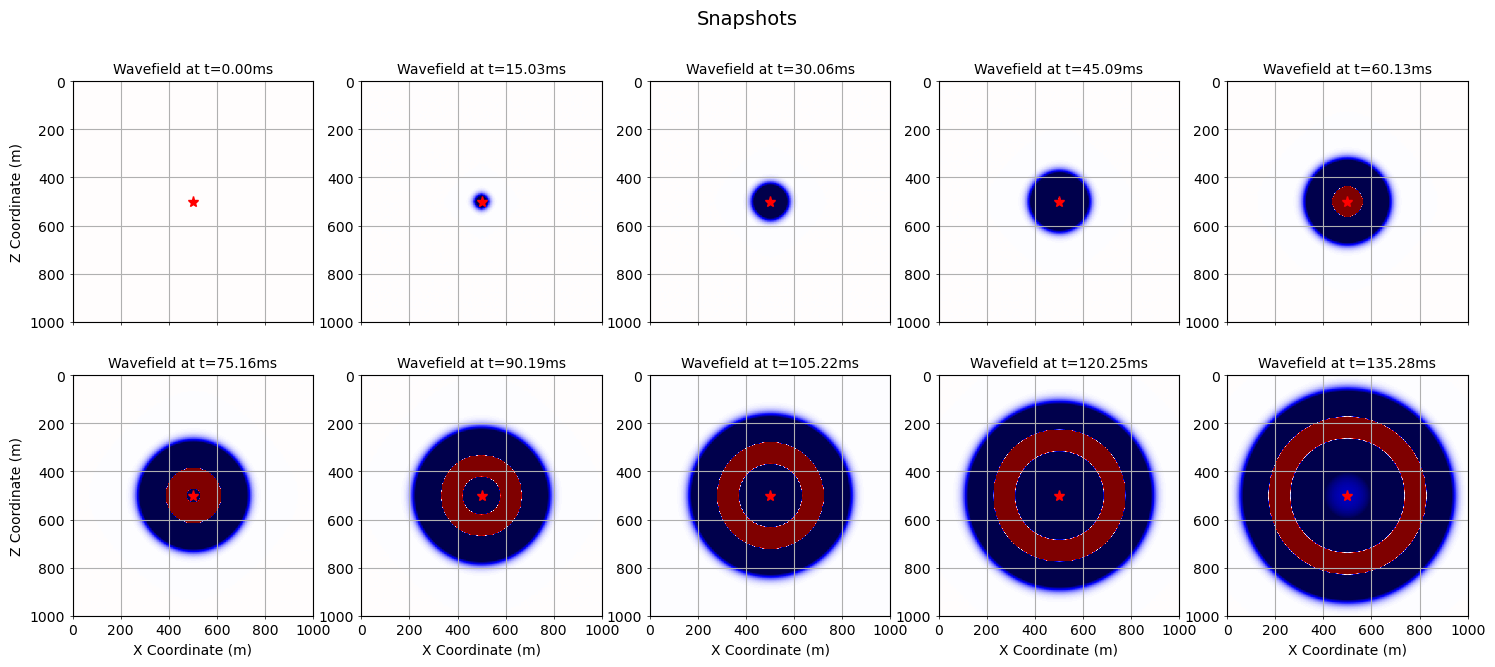

In [9]:
# NBVAL_IGNORE_OUTPUT

# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
              origin_pad[1] + extent_pad[1], origin_pad[1]]

# Plot the wavefields, each normalized to scaled maximum of last time step
kt = (time_range.num - 2) - 1
amax = 0.05 * np.max(np.abs(psave[kt,:,:]))

nsnaps = 10
factor = round(time_range.num/nsnaps)

fig, axes = plt.subplots(2, 5, figsize=(18, 7), sharex=True)
fig.suptitle("Snapshots", size=14)
for count, ax in enumerate(axes.ravel()):
    snapshot = factor*count
    ax.imshow(np.transpose(psave[snapshot,:,:]), cmap="seismic",
               vmin=-amax, vmax=+amax, extent=plt_extent)
    ax.plot(model.domain_size[0]* .5, model.domain_size[1]* .5, \
         'red', linestyle='None', marker='*', markersize=8, label="Source")
    ax.grid()
    ax.tick_params('both', length=2, width=0.5, which='major',labelsize=10)
    ax.set_title("Wavefield at t=%.2fms" % (factor*count*dt),fontsize=10)
for ax in axes[1, :]:
    ax.set_xlabel("X Coordinate (m)",fontsize=10)
for ax in axes[:, 0]:
    ax.set_ylabel("Z Coordinate (m)",fontsize=10)